In [8]:
import pandas as pd 
import numpy as np
import seaborn as sns
import os
import codecs
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS
from fancyimpute import KNN
from bokeh.sampledata.autompg import autompg as df_raw

In [2]:
def missingSummary(data):
    total = data.isnull().sum()
    remaining = len(data) - total
    percent = data.isnull().sum() / data.isnull().count() * 100
    missingdf = pd.concat([total, remaining, percent], axis=1, keys=['Total', 'Remaining', 'Percent'])
    return round(missingdf.sort_values('Percent', ascending=False),2)

In [44]:
def cleanData(data, missingdf, colCutoff, rowCutoff):
    cols_to_drop = list(missingdf[missingdf['Percent'] >= colCutoff].index)
    rows_to_drop = list(missingdf[missingdf['Percent'] <= rowCutoff].index)
    
    cleanData = data.copy()
    cleanData = cleanData.drop(cols_to_drop, axis=1)
    cleanData = cleanData.dropna()
    
    cleanData_missing = missingSummary(cleanData)
    
    return cleanData, cleanData_missing

In [ ]:
def imputation(data, process):
    from sklearn.preprocessing import Imputer
    if process in ('bfill', 'fill'):
        return data.fillna(how=process, inplace=True)
    elif process in ('mean', 'median', 'most_frequent'):
        impute = Imputer(strategy=process)
        imputedData = impute.fit.transform(data)
        return imputedData
    else:
        nn = int(input('How many nearest neighbors? '))
        

In [3]:
def scoreToNPSCat(x):
    if x > 8:
        return 'Promoter'
    elif x > 6:
        return 'Passive'
    else:
        return 'Detractor'

In [9]:
def corpus(data, filename):
    data.dropna(how='any',inplace=True)
    text=list(data.str.lower())
    file = codecs.open(filename, 'w', 'utf-8')
    
    for comment in text:
        file.write(comment)
        file.write('\n')
    
    file.close()
    print('File written successfully')
    return

In [42]:
def wordCount(data):
    cwd=os.getcwd()
    file=open(cwd + '/' + data, 'r')
    counter={}
    
    for word in file.read().split():
        if word not in counter:
            counter[word]=1
        else:
            counter[word]+=1
            
    #Initiate Wordcloud
#     wc = WordCloud.generate_from_frequencies(counter, frequencies='Count')
    
    counterFrame=pd.Series(counter).to_frame()
    counterFrame.columns=['Count']
    
    return counterFrame.sort_values('Count', ascending=False)

In [20]:
df_raw.head()

,mpg,cyl,displ,hp,weight,accel,yr,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [11]:
round(df_raw.describe(),2)

,mpg,cyl,displ,hp,weight,accel,yr,origin
count,392.00,392.00,392.00,392.00,392.00,392.00,392.00,392.00
mean,23.45,5.47,194.41,104.47,2977.58,15.54,75.98,1.58
std,7.81,1.71,104.64,38.49,849.40,2.76,3.68,0.81
min,9.00,3.00,68.00,46.00,1613.00,8.00,70.00,1.00
25%,17.00,4.00,105.00,75.00,2225.25,13.78,73.00,1.00
50%,22.75,4.00,151.00,93.50,2803.50,15.50,76.00,1.00
75%,29.00,8.00,275.75,126.00,3614.75,17.02,79.00,2.00
max,46.60,8.00,455.00,230.00,5140.00,24.80,82.00,3.00


In [19]:
round(pd.pivot_table(df_raw, index='cyl', columns='origin', values=['mpg'], aggfunc='mean'),2).fillna(0)

mpg              
origin      1      2      3
cyl                        
3        0.00   0.00  20.55
4       28.01  28.11  31.60
5        0.00  27.37   0.00
6       19.65  20.10  23.88
8       14.96   0.00   0.00

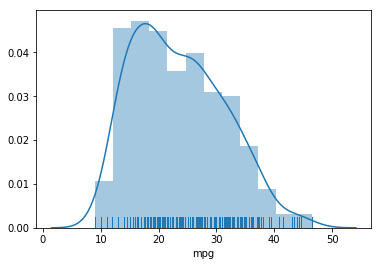

In [29]:
sns.distplot(df_raw.mpg, kde=True, rug=True)

In [40]:
corpus(df_raw.name, 'comments.txt')

File written successfully


In [43]:
wc = wordCount('comments.txt')
wc.head()

,Count
ford,48
chevrolet,43
plymouth,31
dodge,28
(sw),28


In [65]:
mpg_by_cyl = round(pd.pivot_table(df_raw, index='cyl', values=['mpg'], aggfunc='mean'),2)
mpg_by_cyl

,mpg
cyl,
3,20.55
4,29.28
5,27.37
6,19.97
8,14.96


In [67]:
cyl_count = pd.DataFrame(df_raw.cyl.value_counts())
cyl_count

,cyl
4,199
8,103
6,83
3,4
5,3
